## Importing Libraries

In [129]:
import pandas as pd 
import os
import numpy as np
import tifffile
from PIL import Image

In [130]:
!pip install imgaug

In [131]:
# Paths
image_dir = "/kaggle/input/floodd/data/images"
mask_dir = "/kaggle/input/floodd/data/labels"

## Read Data & Turn it into arrays

In [132]:
# Match up images and masks by their numeric part before the extension
def extract_id(filename):
    return filename.split('.')[0]  # Gets '86' from '86.tif', etc.

# Get all image and mask ids (as strings)
image_ids = {extract_id(f) for f in os.listdir(image_dir)}
mask_ids = {extract_id(f) for f in os.listdir(mask_dir)}

# Only keep image ids that have a corresponding mask
common_ids = sorted(list(image_ids & mask_ids))

# Prepare arrays
X_list, Y_list = [], []

for img_id in common_ids:
    img_path = os.path.join(image_dir, img_id + '.tif')
    mask_path = None
    # Try .png first
    if os.path.exists(os.path.join(mask_dir, img_id + '.png')):
        mask_path = os.path.join(mask_dir, img_id + '.png')
    elif os.path.exists(os.path.join(mask_dir, img_id + '.tif')):
        mask_path = os.path.join(mask_dir, img_id + '.tif')
    else:
        continue  # No valid mask file, skip

    # Read image
    img = tiff.imread(img_path).astype(np.float32)  # shape: (128,128,12)
    # Read mask
    mask = np.array(Image.open(mask_path))
    # Binzarize
    mask = (mask > 0).astype(np.uint8)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)
    # Append to list
    X_list.append(img)
    Y_list.append(mask)

X = np.stack(X_list)  # shape: (N,128,128,12)
Y = np.stack(Y_list)  # shape: (N,128,128)

In [133]:
print("X shape:", X.shape)  # (N, 128,128,12)
print("Y shape:", Y.shape)  # (N, 128,128,1)

X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


## Visualizing random samples

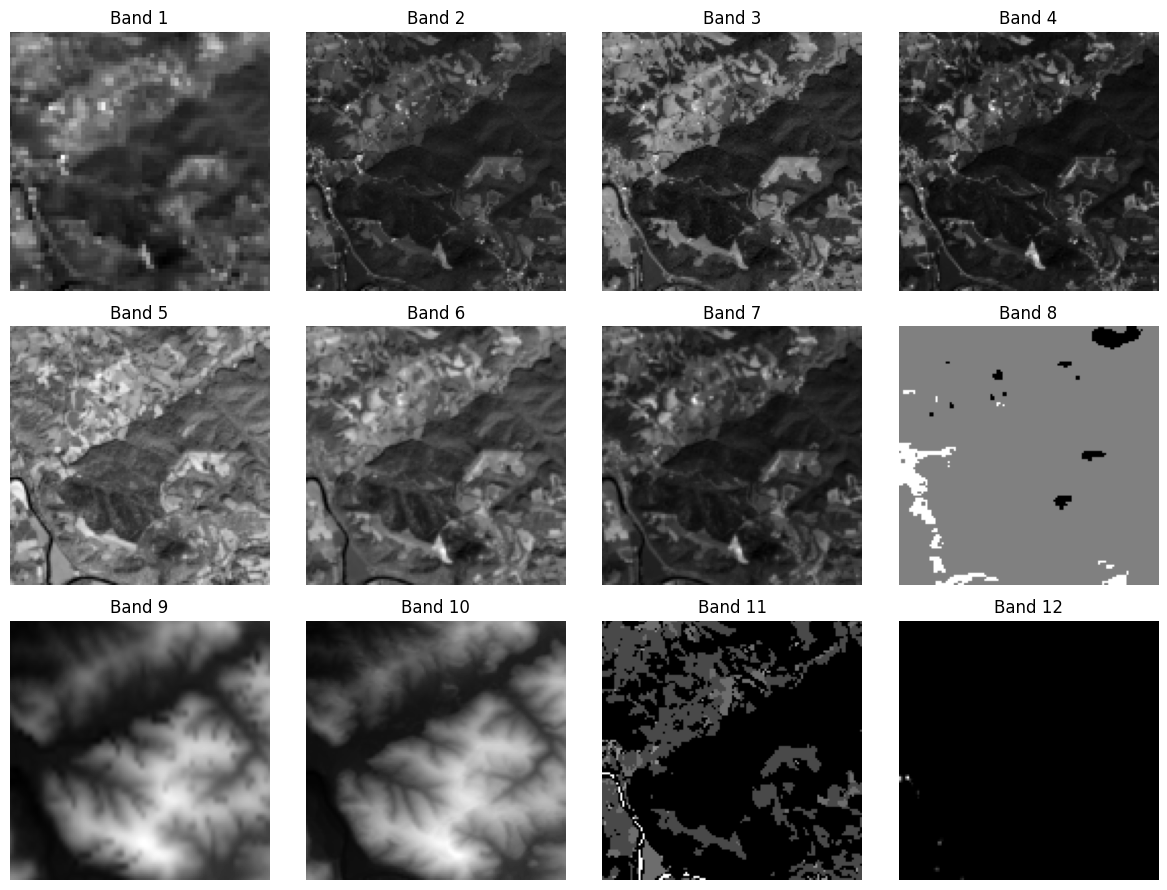

In [134]:
# 6. Visualization: Plot each band of the first image
fig, axs = plt.subplots(3,4, figsize=(12,9))
for i in range(12):
    ax = axs[i//4, i%4]
    ax.imshow(X_norm[1,...,i], cmap='gray')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [135]:
X = np.array(images, dtype=np.float32)
Y = np.array(masks, dtype=np.float32)

In [136]:
# 5. Normalization (per-band min-max normalization across dataset)
X_norm = np.zeros_like(X, dtype=np.float32)
for i in range(X.shape[-1]):
    band = X[...,i]
    band_min = band.min()
    band_max = band.max()
    X_norm[...,i] = (band - band_min) / (band_max - band_min + 1e-8)

# train_test_split

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [138]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(244, 128, 128, 12) (62, 128, 128, 12) (244, 128, 128, 1) (62, 128, 128, 1)


## Data Augmentation

In [139]:
"""""import numpy as np
import imgaug.augmenters as iaa

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),                # flip horizontally
    iaa.Flipud(0.5),                # flip vertically
    iaa.Affine(rotate=(-20, 20)),   # random rotations
    iaa.Affine(scale=(0.9, 1.1)),   # zoom in/out
    iaa.ElasticTransformation(alpha=50, sigma=5), # elastic deformations
    iaa.GaussianBlur(sigma=(0, 1.0)) # blur images a bit
], random_order=True)

# Augment images and masks together
def augment_data(X_train, Y_train, n_aug=2):
    
    Augment X_train, Y_train using imgaug
    n_aug = how many augmented copies per image
    
    X_aug, Y_aug = [], []

    for i in range(len(X_train)):
        for _ in range(n_aug):
            # Apply the same augmentation to image and mask
            det = seq.to_deterministic()
            img_aug = det.augment_image(X_train[i])
            mask_aug = det.augment_image(Y_train[i])

            X_aug.append(img_aug)
            Y_aug.append(mask_aug)

    # Convert back to numpy
    X_aug = np.array(X_aug)
    Y_aug = np.array(Y_aug)

    # Concatenate with original data
    X_out = np.concatenate([X_train, X_aug], axis=0)
    Y_out = np.concatenate([Y_train, Y_aug], axis=0)

    return X_out, Y_out

# Example usage:
X_train_aug, Y_train_aug = augment_data(X_train, Y_train, n_aug=3)

print("Original:", X_train.shape, Y_train.shape)
print("Augmented:", X_train_aug.shape, Y_train_aug.shape)"""


'""import numpy as np\nimport imgaug.augmenters as iaa\n\n# Define augmentation pipeline\nseq = iaa.Sequential([\n    iaa.Fliplr(0.5),                # flip horizontally\n    iaa.Flipud(0.5),                # flip vertically\n    iaa.Affine(rotate=(-20, 20)),   # random rotations\n    iaa.Affine(scale=(0.9, 1.1)),   # zoom in/out\n    iaa.ElasticTransformation(alpha=50, sigma=5), # elastic deformations\n    iaa.GaussianBlur(sigma=(0, 1.0)) # blur images a bit\n], random_order=True)\n\n# Augment images and masks together\ndef augment_data(X_train, Y_train, n_aug=2):\n    \n    Augment X_train, Y_train using imgaug\n    n_aug = how many augmented copies per image\n    \n    X_aug, Y_aug = [], []\n\n    for i in range(len(X_train)):\n        for _ in range(n_aug):\n            # Apply the same augmentation to image and mask\n            det = seq.to_deterministic()\n            img_aug = det.augment_image(X_train[i])\n            mask_aug = det.augment_image(Y_train[i])\n\n            X_a

## Split The Data

In [140]:
"""import numpy as np
from sklearn.model_selection import train_test_split

# Images shape: (794, 128, 128, 12)
# Masks shape: (794, 128, 128)

# X = الصور
# Y = الماسك
X =  X_train_aug 
Y = Y_train_aug 

# أول حاجة: Train + Temp (Val+Test)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=True
)  
# دلوقتي Train = 70% ، Temp = 30%

# تاني خطوة: نقسم الـ Temp نصين → Validation + Test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True
)  
# كده: Validation = 15% ، Test = 15%

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)
"""

'import numpy as np\nfrom sklearn.model_selection import train_test_split\n\n# Images shape: (794, 128, 128, 12)\n# Masks shape: (794, 128, 128)\n\n# X = الصور\n# Y = الماسك\nX =  X_train_aug \nY = Y_train_aug \n\n# أول حاجة: Train + Temp (Val+Test)\nX_train, X_temp, Y_train, Y_temp = train_test_split(\n    X, Y, test_size=0.3, random_state=42, shuffle=True\n)  \n# دلوقتي Train = 70% ، Temp = 30%\n\n# تاني خطوة: نقسم الـ Temp نصين → Validation + Test\nX_val, X_test, Y_val, Y_test = train_test_split(\n    X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True\n)  \n# كده: Validation = 15% ، Test = 15%\n\nprint("Train:", X_train.shape, Y_train.shape)\nprint("Validation:", X_val.shape, Y_val.shape)\nprint("Test:", X_test.shape, Y_test.shape)\n'

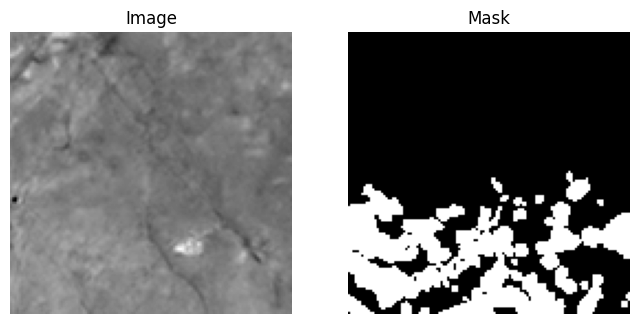

In [169]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(X)-1)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(X[idx,...,0], cmap="gray")   # show first channel
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Y[idx,...,0], cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()


In [170]:
print("Mask unique values:", np.unique(Y))


Mask unique values: [0. 1.]


## Build The Unet Model

In [178]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss


In [179]:
#  U-Net Architecture
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.models import Model

def unet_model(input_shape, dropout_rate=0.3):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    c1 = Dropout(dropout_rate)(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    c2 = Dropout(dropout_rate)(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    c3 = Dropout(dropout_rate)(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    c4 = Dropout(dropout_rate)(c4)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)
    c5 = Dropout(dropout_rate)(c5)

    # Decoder
    u6 = Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)
    c6 = Dropout(dropout_rate)(c6)

    u7 = Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)
    c7 = Dropout(dropout_rate)(c7)

    u8 = Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)
    c8 = Dropout(dropout_rate)(c8)

    u9 = Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)
    c9 = Dropout(dropout_rate)(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce by half
    patience=5,       # after 5 epochs of no improvement
    min_lr=1e-6       # don’t go lower than this
)

model = unet_model((128,128,12))

In [180]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_263 (Conv2D) │ (None, 128, 128,  │      3,488 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_264 (Conv2D) │ (None, 128, 128,  │      9,248 │ conv2d_263[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 128, 128,  │          0 │ conv2d_264[0][0]  │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_60    │ (None, 64, 64,    │          0 │ dropout_70[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_265 (Conv2D) │ (None, 64, 64,    │     18,496 │ max_pooling2d_60… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_266 (Conv2D) │ (None, 64, 64,    │     36,928 │ conv2d_265[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 64, 64,    │          0 │ conv2d_266[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (None, 32, 32,    │          0 │ dropout_71[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_267 (Conv2D) │ (None, 32, 32,    │     73,856 │ max_pooling2d_61… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_268 (Conv2D) │ (None, 32, 32,    │    147,584 │ conv2d_267[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 32, 32,    │          0 │ conv2d_268[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_62    │ (None, 16, 16,    │          0 │ dropout_72[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_269 (Conv2D) │ (None, 16, 16,    │    295,168 │ max_pooling2d_62… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_270 (Conv2D) │ (None, 16, 16,    │    590,080 │ conv2d_269[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 16, 16,    │          0 │ conv2d_270[0][0]  │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (None, 8, 8, 256) │          0 │ dropout_73[0][0]

 Total params: 7,762,689 (29.61 MB)

 Trainable params: 7,762,689 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[dice_loss])



In [182]:
history = model.fit(
    X_train, Y_train[...,np.newaxis],
    validation_split=0.2,
    epochs=30,
    batch_size=15,
     callbacks=[lr_scheduler]
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - dice_loss: 0.5154 - loss: 161.4800 - val_dice_loss: 0.7765 - val_loss: 16.2469 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - dice_loss: 0.6991 - loss: 36.2689 - val_dice_loss: 0.9128 - val_loss: 13.0400 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - dice_loss: 0.6925 - loss: 23.4393 - val_dice_loss: 0.7707 - val_loss: 7.3590 - learning_rate: 1.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - dice_loss: 0.6752 - loss: 17.3348 - val_dice_loss: 0.7871 - val_loss: 4.8743 - learning_rate: 1.0000e-04
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - dice_loss: 0.6555 - loss: 14.9473 - val_dice_loss: 0.7804 - val_loss: 3.7964 - learning_rate: 1.0000e-04
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - dice_loss: 0.6869 - loss: 10.9222 - val_dice_loss: 0.7798 - val_loss: 3.2704 - learning_rate: 1.0000e-04
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101

## Plots To Evaluate The Performance

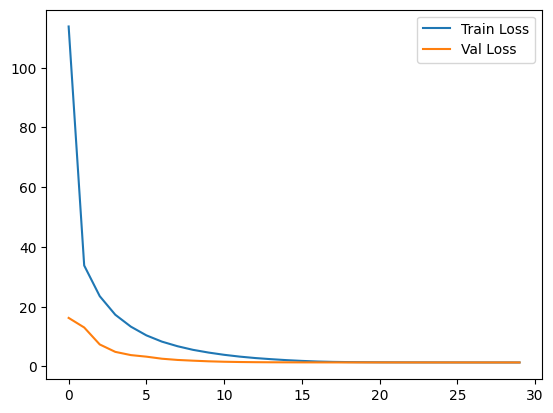

In [187]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.show()



In [166]:
import numpy as np

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)  # Threshold 0.5
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# IoU
def iou_score(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [167]:
# X_test: (num_samples, 128, 128, 12)
# Y_test: (num_samples, 128, 128, 1)

Y_pred = model.predict(X_test)  # Output probabilities


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step


## IOU & Dice coefficient

In [185]:
dice_scores = []
iou_scores = []

for i in range(len(Y_test)):
    dice = dice_loss(Y_test[i], Y_pred[i])
    
    dice_scores.append(dice)
print("Average Dice coefficient:", np.mean(dice_scores))


Average Dice coefficient: 0.7351475


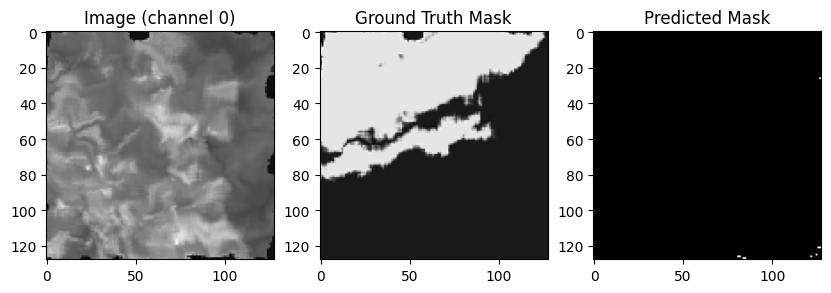

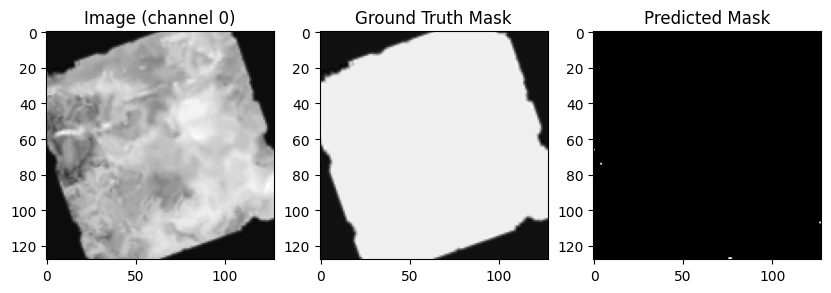

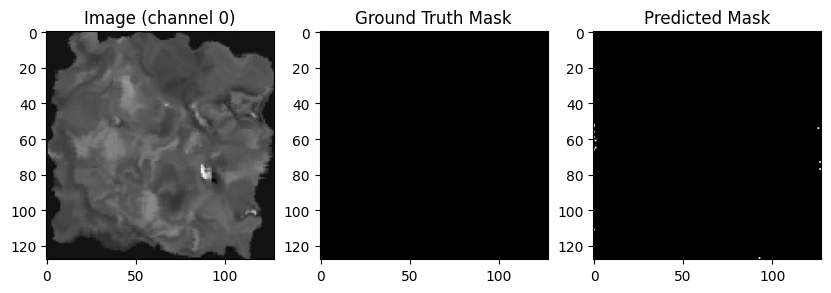

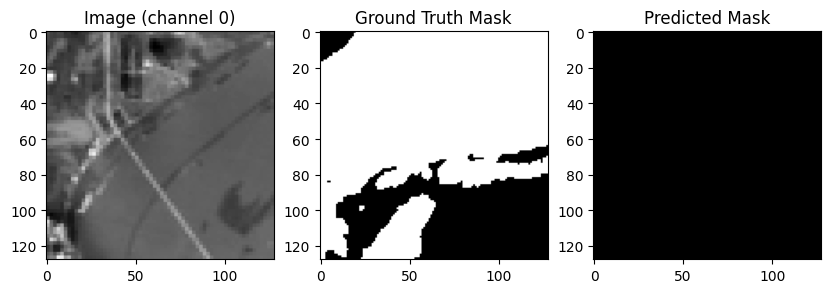

In [186]:
import matplotlib.pyplot as plt

num_samples_to_show = 4
for i in range(num_samples_to_show):
    plt.figure(figsize=(10,3))
    
    # Original image (1st channel for visualization)
    plt.subplot(1,3,1)
    plt.imshow(X_test[i,:,:,0], cmap='gray')
    plt.title("Image (channel 0)")
    
    # Ground truth mask
    plt.subplot(1,3,2)
    plt.imshow(Y_test[i,:,:,0], cmap='gray')
    plt.title("Ground Truth Mask")
    
    # Predicted mask (thresholded at 0.5)
    plt.subplot(1,3,3)
    plt.imshow((Y_pred[i,:,:,0] > 0.5), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()


In [188]:
model.save('Flood_Detection_final.h5')